In [1]:
# path setup
import sys
import os
module_path = os.path.abspath(os.path.join('../../'))
sys.path.insert(1, module_path + "/utils")

## db setup
# pip install sqlalchemy
from sqlalchemy import create_engine
from getpass import getpass 

# pandas setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from data_from_db import get_table_from_shelter
from eda import all_days_present, extended_describe, print_correlation_matrix, plot_boxplot_and_countplot, plot_categorical_features,cramers_v
from model_helper import build_regression_models, preprocess_data

In [2]:
df = get_table_from_shelter('shelter_climate')

In [3]:
df

,date,location_city,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground
0,01.01.24,Toronto,Families,Motel/Hotel Shelter,Room,149.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0
1,01.01.24,Toronto,Mixed Adult,Motel/Hotel Shelter,Room,57.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0
2,01.01.24,Toronto,Mixed Adult,Shelter,Bed,8.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0
3,01.01.24,Toronto,Families,Motel/Hotel Shelter,Room,67.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0
4,01.01.24,Toronto,Families,Motel/Hotel Shelter,Room,161.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128344,31.12.23,Toronto,Youth,Shelter,Bed,31.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0
128345,31.12.23,Toronto,Women,Shelter,Bed,27.0,1.0,0.964286,0.035714,-1.0,2.3,0.3,1.6,0.0
128346,31.12.23,Toronto,Youth,Shelter,Bed,27.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0
128347,31.12.23,Etobicoke,Youth,Shelter,Bed,33.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0


#### focus on toronto

In [4]:
df = df[df['location_city'] == 'Toronto']
df.drop(columns='location_city', inplace=True)

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_95833/2995066481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='location_city', inplace=True)


In [5]:
df['total_units'] = df['taken_units'] + df['free_units']
df

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_95833/1407382162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_units'] = df['taken_units'] + df['free_units']


,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,total_units
0,01.01.24,Families,Motel/Hotel Shelter,Room,149.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,149.0
1,01.01.24,Mixed Adult,Motel/Hotel Shelter,Room,57.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,57.0
2,01.01.24,Mixed Adult,Shelter,Bed,8.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,8.0
3,01.01.24,Families,Motel/Hotel Shelter,Room,67.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,67.0
4,01.01.24,Families,Motel/Hotel Shelter,Room,161.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128342,31.12.23,Youth,Shelter,Bed,40.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,40.0
128343,31.12.23,Women,Shelter,Bed,30.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,30.0
128344,31.12.23,Youth,Shelter,Bed,31.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,31.0
128345,31.12.23,Women,Shelter,Bed,27.0,1.0,0.964286,0.035714,-1.0,2.3,0.3,1.6,0.0,28.0


In [6]:
df.groupby(['sector', 'overnight_service_type', 'capacity_type']).size().reset_index(name='count')

,sector,overnight_service_type,capacity_type,count
0,Families,Motel/Hotel Shelter,Room,7198
1,Families,Shelter,Bed,450
2,Families,Shelter,Room,7002
3,Men,24-Hour Respite Site,Bed,659
4,Men,Motel/Hotel Shelter,Room,2728
5,Men,Shelter,Bed,18565
6,Mixed Adult,24-Hour Respite Site,Bed,7881
7,Mixed Adult,Motel/Hotel Shelter,Bed,254
8,Mixed Adult,Motel/Hotel Shelter,Room,11381
9,Mixed Adult,Shelter,Bed,10363


In [7]:
df.groupby(['sector', 'capacity_type']).size().reset_index(name='count')

,sector,capacity_type,count
0,Families,Bed,450
1,Families,Room,14200
2,Men,Bed,19224
3,Men,Room,2728
4,Mixed Adult,Bed,19399
5,Mixed Adult,Room,11381
6,Women,Bed,18161
7,Women,Room,2810
8,Youth,Bed,12223
9,Youth,Room,4871


In [8]:
df.groupby(['capacity_type']).size().reset_index(name='count')

,capacity_type,count
0,Bed,69457
1,Room,35990


#### add boolean mark

In [9]:
df['is_freezing'] = (df['snow_on_ground'] != 0).astype(int)
df

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_95833/1959132576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_freezing'] = (df['snow_on_ground'] != 0).astype(int)


,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,total_units,is_freezing
0,01.01.24,Families,Motel/Hotel Shelter,Room,149.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,149.0,1
1,01.01.24,Mixed Adult,Motel/Hotel Shelter,Room,57.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,57.0,1
2,01.01.24,Mixed Adult,Shelter,Bed,8.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,8.0,1
3,01.01.24,Families,Motel/Hotel Shelter,Room,67.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,67.0,1
4,01.01.24,Families,Motel/Hotel Shelter,Room,161.0,0.0,1.000000,0.000000,-3.1,0.1,-1.9,-0.7,2.0,161.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128342,31.12.23,Youth,Shelter,Bed,40.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,40.0,0
128343,31.12.23,Women,Shelter,Bed,30.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,30.0,0
128344,31.12.23,Youth,Shelter,Bed,31.0,0.0,1.000000,0.000000,-1.0,2.3,0.3,1.6,0.0,31.0,0
128345,31.12.23,Women,Shelter,Bed,27.0,1.0,0.964286,0.035714,-1.0,2.3,0.3,1.6,0.0,28.0,0


#### add is_weekday

In [10]:
df['date'].dtypes

dtype('O')

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%y')
df.dtypes

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_95833/55058542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%d.%m.%y')


date                      datetime64[ns]
sector                            object
overnight_service_type            object
capacity_type                     object
taken_units                      float64
free_units                       float64
capacity_rate                    float64
availability                     float64
min_temperature                  float64
total_precipitation              float64
mean_temperature                 float64
max_temperature                  float64
snow_on_ground                   float64
total_units                      float64
is_freezing                        int64
dtype: object

In [12]:
df = df.sort_values(by='date')
df

,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,total_units,is_freezing
9775,2021-01-01,Mixed Adult,Motel/Hotel Shelter,Room,252.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,252.0,0
9768,2021-01-01,Men,Motel/Hotel Shelter,Room,45.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,45.0,0
9767,2021-01-01,Men,Shelter,Bed,25.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,25.0,0
9766,2021-01-01,Mixed Adult,24-Hour Respite Site,Bed,45.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,45.0,0
9765,2021-01-01,Mixed Adult,Motel/Hotel Shelter,Room,230.0,5.0,0.978723,0.021277,-1.0,6.8,0.7,2.5,0.0,235.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9641,2024-03-31,Women,Shelter,Bed,88.0,0.0,1.000000,0.000000,2.0,0.0,5.3,8.6,0.0,88.0,0
9640,2024-03-31,Mixed Adult,Motel/Hotel Shelter,Room,64.0,1.0,0.984615,0.015385,2.0,0.0,5.3,8.6,0.0,65.0,0
9639,2024-03-31,Men,Shelter,Bed,107.0,0.0,1.000000,0.000000,2.0,0.0,5.3,8.6,0.0,107.0,0
9662,2024-03-31,Women,Shelter,Bed,60.0,0.0,1.000000,0.000000,2.0,0.0,5.3,8.6,0.0,60.0,0


In [13]:
df.groupby(df['date'].dt.date)['total_units'].sum().reset_index()

,date,total_units
0,2021-01-01,3106.0
1,2021-01-02,3099.0
2,2021-01-03,3096.0
3,2021-01-04,3119.0
4,2021-01-05,3129.0
...,...,...
1181,2024-03-27,5467.0
1182,2024-03-28,5456.0
1183,2024-03-29,5461.0
1184,2024-03-30,5453.0


In [14]:
df.groupby([df['date'].dt.date, 'capacity_type'])[['taken_units', 'free_units', 'total_units']].sum().reset_index()

,date,capacity_type,taken_units,free_units,total_units
0,2021-01-01,Bed,1702.0,75.0,1777.0
1,2021-01-01,Room,1286.0,43.0,1329.0
2,2021-01-02,Bed,1702.0,72.0,1774.0
3,2021-01-02,Room,1290.0,35.0,1325.0
4,2021-01-03,Bed,1687.0,82.0,1769.0
...,...,...,...,...,...
2367,2024-03-29,Room,2022.0,4.0,2026.0
2368,2024-03-30,Bed,3417.0,10.0,3427.0
2369,2024-03-30,Room,2024.0,2.0,2026.0
2370,2024-03-31,Bed,3412.0,15.0,3427.0


In [15]:
df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6])
df.head()

,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,total_units,is_freezing,is_weekend
9775,2021-01-01,Mixed Adult,Motel/Hotel Shelter,Room,252.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,252.0,0,False
9768,2021-01-01,Men,Motel/Hotel Shelter,Room,45.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,45.0,0,False
9767,2021-01-01,Men,Shelter,Bed,25.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,25.0,0,False
9766,2021-01-01,Mixed Adult,24-Hour Respite Site,Bed,45.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,45.0,0,False
9765,2021-01-01,Mixed Adult,Motel/Hotel Shelter,Room,230.0,5.0,0.978723,0.021277,-1.0,6.8,0.7,2.5,0.0,235.0,0,False


In [16]:
df.groupby(df['date'].dt.date)['is_weekend'].max().reset_index()

,date,is_weekend
0,2021-01-01,False
1,2021-01-02,True
2,2021-01-03,True
3,2021-01-04,False
4,2021-01-05,False
...,...,...
1181,2024-03-27,False
1182,2024-03-28,False
1183,2024-03-29,False
1184,2024-03-30,True


In [17]:
df['binned_sector'] = df['sector'].replace({'Men': 'Adults', 'Women': 'Adults', 'Mixed Adult': 'Adults'})

In [18]:
df

,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,total_units,is_freezing,is_weekend,binned_sector
9775,2021-01-01,Mixed Adult,Motel/Hotel Shelter,Room,252.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,252.0,0,False,Adults
9768,2021-01-01,Men,Motel/Hotel Shelter,Room,45.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,45.0,0,False,Adults
9767,2021-01-01,Men,Shelter,Bed,25.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,25.0,0,False,Adults
9766,2021-01-01,Mixed Adult,24-Hour Respite Site,Bed,45.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,45.0,0,False,Adults
9765,2021-01-01,Mixed Adult,Motel/Hotel Shelter,Room,230.0,5.0,0.978723,0.021277,-1.0,6.8,0.7,2.5,0.0,235.0,0,False,Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9641,2024-03-31,Women,Shelter,Bed,88.0,0.0,1.000000,0.000000,2.0,0.0,5.3,8.6,0.0,88.0,0,True,Adults
9640,2024-03-31,Mixed Adult,Motel/Hotel Shelter,Room,64.0,1.0,0.984615,0.015385,2.0,0.0,5.3,8.6,0.0,65.0,0,True,Adults
9639,2024-03-31,Men,Shelter,Bed,107.0,0.0,1.000000,0.000000,2.0,0.0,5.3,8.6,0.0,107.0,0,True,Adults
9662,2024-03-31,Women,Shelter,Bed,60.0,0.0,1.000000,0.000000,2.0,0.0,5.3,8.6,0.0,60.0,0,True,Adults


In [19]:
df.to_csv('../../data/processed/overview.csv', index=False)

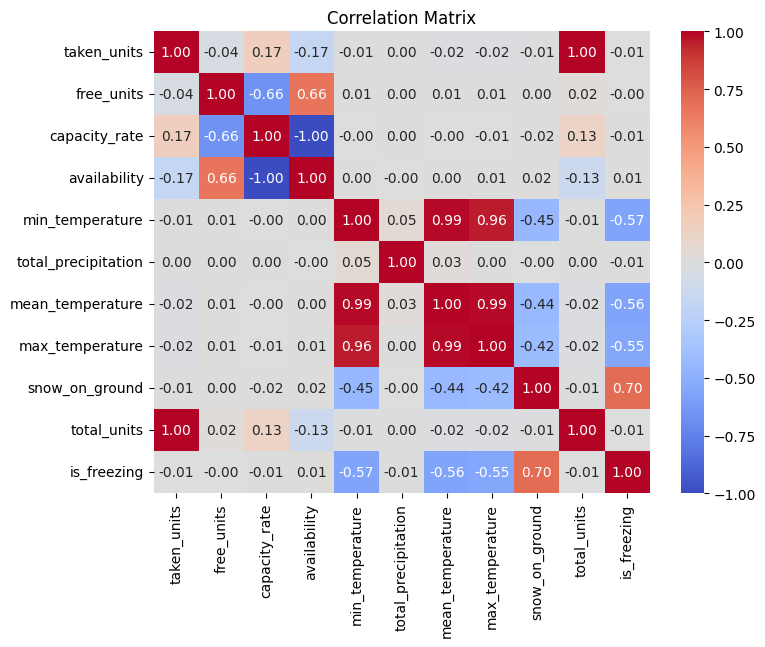

In [20]:
numerical = df.select_dtypes(include=['int64', 'float64'])
print_correlation_matrix(numerical)

In [21]:
warming_df = df[df['overnight_service_type'] == 'Warming Centre']
warming_df


,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,total_units,is_freezing,is_weekend,binned_sector
12036,2021-01-22,Mixed Adult,Warming Centre,Bed,24.0,26.0,0.480000,0.520000,-6.4,0.3,-1.9,2.6,0.0,50.0,0,False,Adults
12035,2021-01-22,Mixed Adult,Warming Centre,Bed,11.0,21.0,0.343750,0.656250,-6.4,0.3,-1.9,2.6,0.0,32.0,0,False,Adults
12003,2021-01-22,Mixed Adult,Warming Centre,Bed,9.0,6.0,0.600000,0.400000,-6.4,0.3,-1.9,2.6,0.0,15.0,0,False,Adults
12147,2021-01-23,Mixed Adult,Warming Centre,Bed,50.0,0.0,1.000000,0.000000,-10.6,0.0,-7.3,-4.0,0.0,50.0,0,True,Adults
12146,2021-01-23,Mixed Adult,Warming Centre,Bed,29.0,3.0,0.906250,0.093750,-10.6,0.0,-7.3,-4.0,0.0,32.0,0,True,Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9440,2024-03-29,Mixed Adult,Warming Centre,Bed,16.0,2.0,0.888889,0.111111,0.5,0.0,4.4,8.3,0.0,18.0,0,False,Adults
9527,2024-03-30,Mixed Adult,Warming Centre,Bed,45.0,3.0,0.937500,0.062500,-0.9,0.0,3.3,7.5,0.0,48.0,0,True,Adults
9545,2024-03-30,Mixed Adult,Warming Centre,Bed,9.0,1.0,0.900000,0.100000,-0.9,0.0,3.3,7.5,0.0,10.0,0,True,Adults
9632,2024-03-31,Mixed Adult,Warming Centre,Bed,43.0,5.0,0.895833,0.104167,2.0,0.0,5.3,8.6,0.0,48.0,0,True,Adults


In [22]:
# Group by 'overnight_service_type' (which is now 'warming_center') and count the total and taken units
grouped = warming_df.groupby('overnight_service_type').agg({'total_units': 'sum', 'taken_units': 'sum'}).reset_index()
grouped

,overnight_service_type,total_units,taken_units
0,Warming Centre,37461.0,34230.0


In [23]:
df['month'] = pd.to_datetime(df['date']).dt.month
df


,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,total_units,is_freezing,is_weekend,binned_sector,month
9775,2021-01-01,Mixed Adult,Motel/Hotel Shelter,Room,252.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,252.0,0,False,Adults,1
9768,2021-01-01,Men,Motel/Hotel Shelter,Room,45.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,45.0,0,False,Adults,1
9767,2021-01-01,Men,Shelter,Bed,25.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,25.0,0,False,Adults,1
9766,2021-01-01,Mixed Adult,24-Hour Respite Site,Bed,45.0,0.0,1.000000,0.000000,-1.0,6.8,0.7,2.5,0.0,45.0,0,False,Adults,1
9765,2021-01-01,Mixed Adult,Motel/Hotel Shelter,Room,230.0,5.0,0.978723,0.021277,-1.0,6.8,0.7,2.5,0.0,235.0,0,False,Adults,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9641,2024-03-31,Women,Shelter,Bed,88.0,0.0,1.000000,0.000000,2.0,0.0,5.3,8.6,0.0,88.0,0,True,Adults,3
9640,2024-03-31,Mixed Adult,Motel/Hotel Shelter,Room,64.0,1.0,0.984615,0.015385,2.0,0.0,5.3,8.6,0.0,65.0,0,True,Adults,3
9639,2024-03-31,Men,Shelter,Bed,107.0,0.0,1.000000,0.000000,2.0,0.0,5.3,8.6,0.0,107.0,0,True,Adults,3
9662,2024-03-31,Women,Shelter,Bed,60.0,0.0,1.000000,0.000000,2.0,0.0,5.3,8.6,0.0,60.0,0,True,Adults,3


In [24]:
df['min_temperature'].corr(df['total_units'])

-0.012205844210637305

In [25]:
warming_df['min_temperature'].corr(df['total_units'])

-0.12816278992852953

In [26]:
warming_df['total_units'].corr(df['snow_on_ground'])

0.13190708241235166

In [27]:
shelter_df = df[df['overnight_service_type'] == 'Shelter']
shelter_df['min_temperature'].corr(df['total_units'])

-0.018663881688252268

In [28]:
warming_df.head()

,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,total_units,is_freezing,is_weekend,binned_sector
12036,2021-01-22,Mixed Adult,Warming Centre,Bed,24.0,26.0,0.48000,0.52000,-6.4,0.3,-1.9,2.6,0.0,50.0,0,False,Adults
12035,2021-01-22,Mixed Adult,Warming Centre,Bed,11.0,21.0,0.34375,0.65625,-6.4,0.3,-1.9,2.6,0.0,32.0,0,False,Adults
12003,2021-01-22,Mixed Adult,Warming Centre,Bed,9.0,6.0,0.60000,0.40000,-6.4,0.3,-1.9,2.6,0.0,15.0,0,False,Adults
12147,2021-01-23,Mixed Adult,Warming Centre,Bed,50.0,0.0,1.00000,0.00000,-10.6,0.0,-7.3,-4.0,0.0,50.0,0,True,Adults
12146,2021-01-23,Mixed Adult,Warming Centre,Bed,29.0,3.0,0.90625,0.09375,-10.6,0.0,-7.3,-4.0,0.0,32.0,0,True,Adults


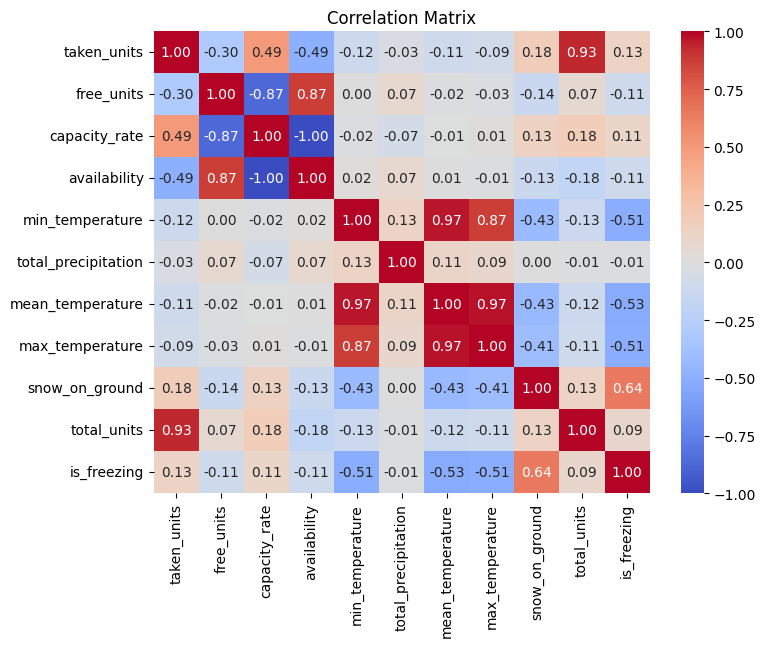

In [29]:
numerical = warming_df.select_dtypes(include=['int64', 'float64'])
print_correlation_matrix(numerical)

In [30]:
numerical.columns

Index(['taken_units', 'free_units', 'capacity_rate', 'availability',
       'min_temperature', 'total_precipitation', 'mean_temperature',
       'max_temperature', 'snow_on_ground', 'total_units', 'is_freezing'],
      dtype='object')

In [31]:
selected_columns = ['taken_units', 'free_units', 'min_temperature', 'mean_temperature','total_precipitation', 'snow_on_ground', 'is_freezing', 'total_units']
numerical = warming_df[selected_columns]

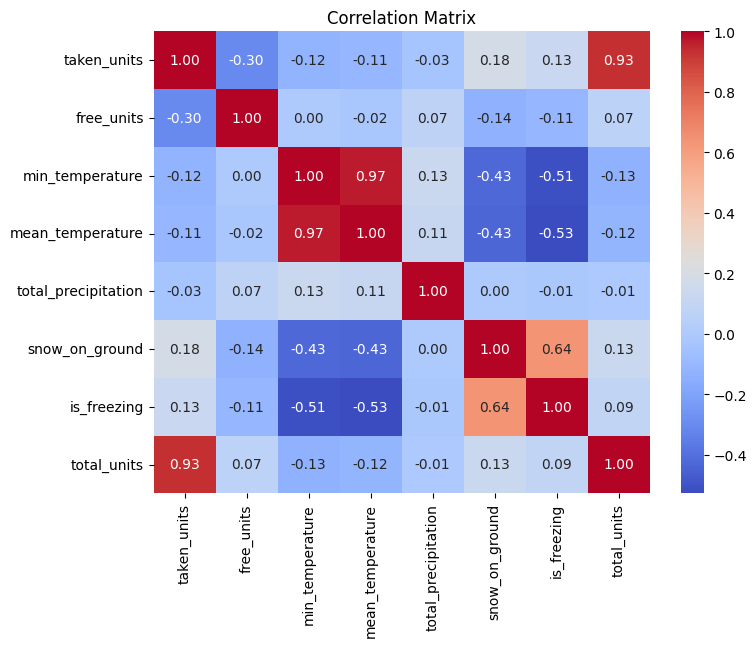

In [32]:
print_correlation_matrix(numerical)

#### build model to predict total_units based on the min_temperature using the rows where overnight_service_type 'Warming Centre'

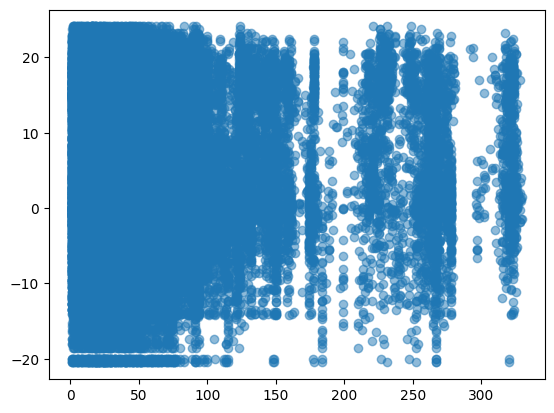

In [33]:
## using all overnight_service_types
plt.scatter(df['total_units'], df['min_temperature'], alpha=0.5)
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

target = 'total_units'
feature = 'min_temperature'

warming_df = df[df['overnight_service_type'] == 'Warming Centre']
warming_df


,date,sector,overnight_service_type,capacity_type,taken_units,free_units,capacity_rate,availability,min_temperature,total_precipitation,mean_temperature,max_temperature,snow_on_ground,total_units,is_freezing,is_weekend,binned_sector,month
12036,2021-01-22,Mixed Adult,Warming Centre,Bed,24.0,26.0,0.480000,0.520000,-6.4,0.3,-1.9,2.6,0.0,50.0,0,False,Adults,1
12035,2021-01-22,Mixed Adult,Warming Centre,Bed,11.0,21.0,0.343750,0.656250,-6.4,0.3,-1.9,2.6,0.0,32.0,0,False,Adults,1
12003,2021-01-22,Mixed Adult,Warming Centre,Bed,9.0,6.0,0.600000,0.400000,-6.4,0.3,-1.9,2.6,0.0,15.0,0,False,Adults,1
12147,2021-01-23,Mixed Adult,Warming Centre,Bed,50.0,0.0,1.000000,0.000000,-10.6,0.0,-7.3,-4.0,0.0,50.0,0,True,Adults,1
12146,2021-01-23,Mixed Adult,Warming Centre,Bed,29.0,3.0,0.906250,0.093750,-10.6,0.0,-7.3,-4.0,0.0,32.0,0,True,Adults,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9440,2024-03-29,Mixed Adult,Warming Centre,Bed,16.0,2.0,0.888889,0.111111,0.5,0.0,4.4,8.3,0.0,18.0,0,False,Adults,3
9527,2024-03-30,Mixed Adult,Warming Centre,Bed,45.0,3.0,0.937500,0.062500,-0.9,0.0,3.3,7.5,0.0,48.0,0,True,Adults,3
9545,2024-03-30,Mixed Adult,Warming Centre,Bed,9.0,1.0,0.900000,0.100000,-0.9,0.0,3.3,7.5,0.0,10.0,0,True,Adults,3
9632,2024-03-31,Mixed Adult,Warming Centre,Bed,43.0,5.0,0.895833,0.104167,2.0,0.0,5.3,8.6,0.0,48.0,0,True,Adults,3


In [35]:
X = df[[feature]]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = model.score(X_test, y_test)
print(f"R-squared score: {r2}")

Mean Squared Error: 2372.914267049557
R-squared score: 0.00014472817624566758


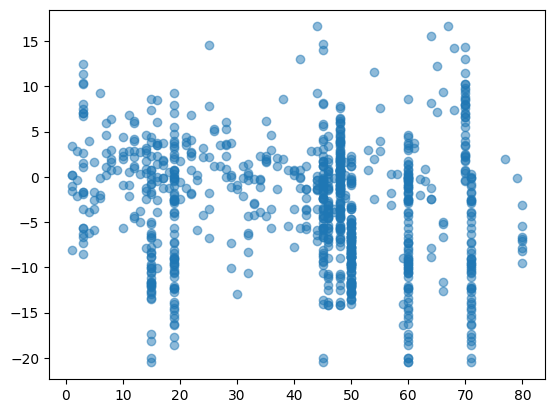

In [36]:
# filtering for warming centers
plt.scatter(warming_df['total_units'], warming_df['min_temperature'], alpha=0.5)
plt.show()

#### build on all data

In [37]:
X = df[[feature]]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = model.score(X_test, y_test)
print(f"R-squared score: {r2}")

Mean Squared Error: 2372.914267049557
R-squared score: 0.00014472817624566758


#### check categorical with total_units

In [38]:
categorical = df.select_dtypes(object)
categorical

,sector,overnight_service_type,capacity_type,binned_sector
9775,Mixed Adult,Motel/Hotel Shelter,Room,Adults
9768,Men,Motel/Hotel Shelter,Room,Adults
9767,Men,Shelter,Bed,Adults
9766,Mixed Adult,24-Hour Respite Site,Bed,Adults
9765,Mixed Adult,Motel/Hotel Shelter,Room,Adults
...,...,...,...,...
9641,Women,Shelter,Bed,Adults
9640,Mixed Adult,Motel/Hotel Shelter,Room,Adults
9639,Men,Shelter,Bed,Adults
9662,Women,Shelter,Bed,Adults


In [39]:
from scipy.stats import chi2_contingency

def chi2_test_categorical(df, target_variable):
    categorical_vars = df.select_dtypes(include=['object']).columns.tolist()
    
    results = {}
    
    for var in categorical_vars:
        contingency_table = pd.crosstab(df[var], df[target_variable])
        chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
        results[var] = {'chi2_stat': chi2_stat, 'p_value': p_val, 'degrees_of_freedom': dof}
    
    return results

In [40]:
# add target to categorical set: 
categorical['total_units'] = df['total_units']
categorical

,sector,overnight_service_type,capacity_type,binned_sector,total_units
9775,Mixed Adult,Motel/Hotel Shelter,Room,Adults,252.0
9768,Men,Motel/Hotel Shelter,Room,Adults,45.0
9767,Men,Shelter,Bed,Adults,25.0
9766,Mixed Adult,24-Hour Respite Site,Bed,Adults,45.0
9765,Mixed Adult,Motel/Hotel Shelter,Room,Adults,235.0
...,...,...,...,...,...
9641,Women,Shelter,Bed,Adults,88.0
9640,Mixed Adult,Motel/Hotel Shelter,Room,Adults,65.0
9639,Men,Shelter,Bed,Adults,107.0
9662,Women,Shelter,Bed,Adults,60.0


In [41]:
# Example usage
results = chi2_test_categorical(categorical, 'total_units')
for var, stats in results.items():
    print(f"Chi-square test for {var}:")
    print(f"Chi-square statistic: {stats['chi2_stat']}")
    print(f"Degrees of freedom: {stats['degrees_of_freedom']}")
    print(f"p-value: {stats['p_value']}")
    print()

Chi-square test for sector:
Chi-square statistic: 99841.51376324316
Degrees of freedom: 1236
p-value: 0.0

Chi-square test for overnight_service_type:
Chi-square statistic: 83616.10047784838
Degrees of freedom: 1236
p-value: 0.0

Chi-square test for capacity_type:
Chi-square statistic: 31734.333610195965
Degrees of freedom: 309
p-value: 0.0

Chi-square test for binned_sector:
Chi-square statistic: 42722.49509119096
Degrees of freedom: 618
p-value: 0.0



--> **I'm going to include them in the model**

### model to predict total units for warming center based on min_temp and cetegoricals

In [42]:
# adding on numerical onto categorical
X = df.select_dtypes(object)
X.drop(columns='sector', inplace=True)
X['min_temperature'] = df['min_temperature']
X

,overnight_service_type,capacity_type,binned_sector,min_temperature
9775,Motel/Hotel Shelter,Room,Adults,-1.0
9768,Motel/Hotel Shelter,Room,Adults,-1.0
9767,Shelter,Bed,Adults,-1.0
9766,24-Hour Respite Site,Bed,Adults,-1.0
9765,Motel/Hotel Shelter,Room,Adults,-1.0
...,...,...,...,...
9641,Shelter,Bed,Adults,2.0
9640,Motel/Hotel Shelter,Room,Adults,2.0
9639,Shelter,Bed,Adults,2.0
9662,Shelter,Bed,Adults,2.0


In [43]:
X = X
y = df['total_units']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
## separate cat from num
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(object).columns

X_train_numerical = X_train[numerical_columns]
X_train_categorical = X_train[categorical_columns]

X_test_numerical = X_test[numerical_columns]
X_test_categorical = X_test[categorical_columns]

In [45]:
### one hot encode 
from sklearn.preprocessing import OneHotEncoder

X_train_categorical.columns = [str(col) for col in X_train_categorical.columns]
X_test_categorical.columns = [str(col) for col in X_test_categorical.columns]

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(X_train_categorical)

X_train_cat_hot = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(X_train_categorical.columns))
display(X_train_cat_hot)

# encode test using train encoder
encoded_test_data = encoder.transform(X_test_categorical)
X_test_cat_hot = pd.DataFrame(encoded_test_data, columns=encoder.get_feature_names_out(X_train_categorical.columns))

display(X_test_cat_hot)

,overnight_service_type_24-Hour Women's Drop-in,overnight_service_type_Motel/Hotel Shelter,overnight_service_type_Shelter,overnight_service_type_Warming Centre,capacity_type_Room,binned_sector_Families,binned_sector_Youth
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
84352,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84353,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84354,0.0,0.0,1.0,0.0,0.0,0.0,0.0
84355,0.0,0.0,1.0,0.0,0.0,0.0,1.0


,overnight_service_type_24-Hour Women's Drop-in,overnight_service_type_Motel/Hotel Shelter,overnight_service_type_Shelter,overnight_service_type_Warming Centre,capacity_type_Room,binned_sector_Families,binned_sector_Youth
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
21085,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21086,0.0,1.0,0.0,0.0,1.0,0.0,1.0
21087,0.0,1.0,0.0,0.0,1.0,0.0,0.0
21088,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [46]:
X_train_numerical.reset_index(drop=True, inplace=True)
X_test_numerical.reset_index(drop=True, inplace=True)

In [47]:
X_train = pd.concat([X_train_cat_hot, X_train_numerical], axis=1)

X_test = pd.concat([X_test_cat_hot, X_test_numerical], axis=1)

display(X_train)
display(X_test)

,overnight_service_type_24-Hour Women's Drop-in,overnight_service_type_Motel/Hotel Shelter,overnight_service_type_Shelter,overnight_service_type_Warming Centre,capacity_type_Room,binned_sector_Families,binned_sector_Youth,min_temperature
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.2
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,16.6
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,19.6
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,17.5
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.0
...,...,...,...,...,...,...,...,...
84352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3
84353,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.6
84354,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.6
84355,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-2.0


,overnight_service_type_24-Hour Women's Drop-in,overnight_service_type_Motel/Hotel Shelter,overnight_service_type_Shelter,overnight_service_type_Warming Centre,capacity_type_Room,binned_sector_Families,binned_sector_Youth,min_temperature
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,17.5
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.8
...,...,...,...,...,...,...,...,...
21085,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.4
21086,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-6.9
21087,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-4.4
21088,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1.7


In [48]:

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = model.score(X_test, y_test)
print(f"R-squared score: {r2}")

Mean Squared Error: 2024.3092923189301
R-squared score: 0.14703352504870537


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (Random Forest): {mse_rf}")
print(f"R-squared score (Random Forest): {r2_rf}")

Mean Squared Error (Random Forest): 2050.8080961256173
R-squared score (Random Forest): 0.13586794310963135


In [50]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Mean Squared Error (Gradient Boosting): {mse_gb}")
print(f"R-squared score (Gradient Boosting): {r2_gb}")

Mean Squared Error (Gradient Boosting): 1982.0255947656676
R-squared score (Gradient Boosting): 0.1648502571986612


#### refactor

In [51]:
results = build_regression_models(X_train, X_test, y_train, y_test)
print(results)

               Model  Mean Squared Error  R-squared
0  Linear Regression         2024.309292   0.147034
1      Random Forest         2050.808096   0.135868
2  Gradient Boosting         1982.025595   0.164850


> -- scores are not good 

In [52]:
X = df.select_dtypes(object)
X['total_units'] = df['total_units']
X.drop(columns='sector', inplace=True)
X['min_temperature'] = df['min_temperature']
warming_X = X[X['overnight_service_type'] == 'Warming Centre']
warming_X


,overnight_service_type,capacity_type,binned_sector,total_units,min_temperature
12036,Warming Centre,Bed,Adults,50.0,-6.4
12035,Warming Centre,Bed,Adults,32.0,-6.4
12003,Warming Centre,Bed,Adults,15.0,-6.4
12147,Warming Centre,Bed,Adults,50.0,-10.6
12146,Warming Centre,Bed,Adults,32.0,-10.6
...,...,...,...,...,...
9440,Warming Centre,Bed,Adults,18.0,0.5
9527,Warming Centre,Bed,Adults,48.0,-0.9
9545,Warming Centre,Bed,Adults,10.0,-0.9
9632,Warming Centre,Bed,Adults,48.0,2.0


In [53]:
warming_X.dtypes

overnight_service_type     object
capacity_type              object
binned_sector              object
total_units               float64
min_temperature           float64
dtype: object

In [54]:
X = warming_X.drop(columns='total_units')
y = warming_X['total_units']

In [55]:
X_train, X_test, y_train, y_test = preprocess_data(X, y)

In [56]:
results = build_regression_models(X_train, X_test, y_train, y_test)
print(results)

               Model  Mean Squared Error  R-squared
0  Linear Regression          399.174081   0.012712
1      Random Forest          578.860266  -0.431710
2  Gradient Boosting          475.779671  -0.176758


**i realized that the problem is with the time series data--- looking into data lag, usign time eries models, binning**